## Var name setting

In [1]:
subjectID='3'
noEpochs=1000
noLSTMUnits=100

# Change to true if input file 's features are sorted by time (False by default) 
orderedInput=True

# Change at least one of these 2 variable to true for reading inputFeatures (Can be both)
fourInputFeats=True
HRInputFeats=True
assert fourInputFeats == True or HRInputFeats==True, "Both condition are false!! Need at least one of these 2 variables to true"

# Change number of steps according to Matlab file for testing input data
test_noTimeSteps=2 

# Change to 1 if want to export to CSV O2 precict against test (0 by default)
exportCSV=0

# Chabge to 1 if want to save the training model (0 by default)
savedModel=0

# Set seed value for uniform (NOT RECOMMEND TO CHANGE, by default 12321)
seed_value = 12321

# Getting input file name
if orderedInput:
    orderedPrefix = 'order-'
    sortedPrefix = '_sored'
    fileName='inputFeatures'+subjectID+'_sorted.mat'
else:    
    # Unordered input features
    orderedPrefix = ''
    sortedPrefix = ''
    fileName='inputFeatures'+subjectID+'.mat'

## For testinng purpose
fileName="5inputs.mat"
print("Input file: ",fileName)

Input file:  5inputs.mat


## Include lib

In [2]:
from keras.models import load_model
import scipy.io as sio 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
from datetime import datetime as dt
from keras import backend as K
#from comet_ml import Experiment

## Set seed for training

In [3]:
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Defilne parser function

In [4]:
list_test=[]

"""
The function take number of feature according to data 
and return a list normalized input features data
"""
def parse_input(noFeatures):
    global list_test
    print("Number of features: ",noFeatures)
    if noFeatures==5:
        print("Keep all data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData)
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData)
    elif noFeatures==4:
        print("Remove HR data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,:4])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,:4])
    elif noFeatures==1:
        print("Remove 4 input features")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,-1])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,-1])
    else:
        # Code will runinto this part
        print("Unknown number of features")
        
    print("---------")
    print(np.shape(list_test))    
    list_test=np.vstack(list_test)
    print(np.shape(list_test))
    scaler = StandardScaler()
    scaler=scaler.fit(list_test)
    scaled_list_test=scaler.transform(list_test)
    
    return scaled_list_test

## Read input from Matlab file

In [19]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

i=sio.loadmat(fileName)

TTest=i['TTest']
TTrain=i['TTrain']
XTrain=i['XTrain']
XTest=i['XTest']

XTrain=XTrain.reshape(-1)
TTrain=TTrain.reshape(-1)
XTest=XTest.reshape(-1)
TTest=TTest.reshape(-1)

test=np.transpose(XTrain).reshape(-1)
test2=np.transpose(XTest).reshape(-1)

# Get number of features and number of number of time steps
noFeatures = np.shape(test[0])[0]
noTimeSteps = np.shape(test[0])[1]

# Validate the input data's number of feature and number of time step
assert noTimeSteps == test_noTimeSteps, "The number of time steps does not match our configuration!! Check either of them"
print("The time step now should be ",noTimeSteps)

if fourInputFeats and HRInputFeats:
    assert noFeatures==5, "The number of input features is not 5! Check setting again"
    print("5 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp, heart rate")
    confPrefix="withHR_"
elif fourInputFeats:
    assert noFeatures==4, "The number of input features is not 4! Check setting again"
    print("4 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp")
    confPrefix="NoHR_"
elif HRInputFeats:
    assert noFeatures==1, "The number of input features is not 1! Check setting again"
    print("1 input feture included: Heart rate only")
    confPrefix="onlyHR_"
else:
    ## Both conditions are false, code will not run into this section
    print("Both condition are false!! Need at least ")
    
# Automatically setting name of output files based on configuration    
modelSaveName=confPrefix+'Subj-'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.h5'
figPredictName=confPrefix+'Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'
figRMSEName=confPrefix+'RMSE_Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'

The time step now should be  2
5 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp, heart rate


## Call parser function

In [6]:
scaled_list_test = parse_input(noFeatures)

# Return back input data with scaled value
XT_s_stack=list()
i=0
timeSteps=noTimeSteps
while i+timeSteps <= (len(scaled_list_test)):
    XT_s_stack.append(scaled_list_test[i:i+timeSteps])
    i=i+timeSteps

XT_s_stack=np.stack(XT_s_stack)
cutPoint=np.shape(TTest.reshape(-1))[0]


XTrain_s=XT_s_stack[:-cutPoint,:,:]
XTest_s=XT_s_stack[-cutPoint:,:,:]

Number of features:  5
Keep all data
---------
(45, 2, 5)
(90, 5)


## Configure the model

In [7]:
length = noTimeSteps
n_features = noFeatures
model = Sequential()
model.add(LSTM(noLSTMUnits,input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
with tf.device('/gpu:0'):
    start = dt.now()
    model.fit(XTrain_s,np.array(TTrain),epochs=noEpochs,verbose=2)
    trainTime=(dt.now() - start)

Epoch 1/1000
2/2 - 3s - loss: 3.6031 - 3s/epoch - 1s/step
Epoch 2/1000
2/2 - 0s - loss: 3.5307 - 11ms/epoch - 5ms/step
Epoch 3/1000
2/2 - 0s - loss: 3.4528 - 11ms/epoch - 5ms/step
Epoch 4/1000
2/2 - 0s - loss: 3.3857 - 11ms/epoch - 6ms/step
Epoch 5/1000
2/2 - 0s - loss: 3.3211 - 9ms/epoch - 4ms/step
Epoch 6/1000
2/2 - 0s - loss: 3.2577 - 10ms/epoch - 5ms/step
Epoch 7/1000
2/2 - 0s - loss: 3.1948 - 12ms/epoch - 6ms/step
Epoch 8/1000
2/2 - 0s - loss: 3.1349 - 12ms/epoch - 6ms/step
Epoch 9/1000
2/2 - 0s - loss: 3.0690 - 13ms/epoch - 7ms/step
Epoch 10/1000
2/2 - 0s - loss: 3.0053 - 12ms/epoch - 6ms/step
Epoch 11/1000
2/2 - 0s - loss: 2.9425 - 11ms/epoch - 5ms/step
Epoch 12/1000
2/2 - 0s - loss: 2.8793 - 11ms/epoch - 5ms/step
Epoch 13/1000
2/2 - 0s - loss: 2.8187 - 11ms/epoch - 6ms/step
Epoch 14/1000
2/2 - 0s - loss: 2.7599 - 9ms/epoch - 5ms/step
Epoch 15/1000
2/2 - 0s - loss: 2.6998 - 10ms/epoch - 5ms/step
Epoch 16/1000
2/2 - 0s - loss: 2.6425 - 10ms/epoch - 5ms/step
Epoch 17/1000
2/2 - 0s

Epoch 133/1000
2/2 - 0s - loss: 0.1159 - 12ms/epoch - 6ms/step
Epoch 134/1000
2/2 - 0s - loss: 0.1158 - 12ms/epoch - 6ms/step
Epoch 135/1000
2/2 - 0s - loss: 0.1157 - 11ms/epoch - 5ms/step
Epoch 136/1000
2/2 - 0s - loss: 0.1157 - 12ms/epoch - 6ms/step
Epoch 137/1000
2/2 - 0s - loss: 0.1157 - 11ms/epoch - 6ms/step
Epoch 138/1000
2/2 - 0s - loss: 0.1156 - 9ms/epoch - 4ms/step
Epoch 139/1000
2/2 - 0s - loss: 0.1157 - 10ms/epoch - 5ms/step
Epoch 140/1000
2/2 - 0s - loss: 0.1156 - 11ms/epoch - 6ms/step
Epoch 141/1000
2/2 - 0s - loss: 0.1156 - 10ms/epoch - 5ms/step
Epoch 142/1000
2/2 - 0s - loss: 0.1156 - 11ms/epoch - 5ms/step
Epoch 143/1000
2/2 - 0s - loss: 0.1155 - 13ms/epoch - 6ms/step
Epoch 144/1000
2/2 - 0s - loss: 0.1154 - 11ms/epoch - 5ms/step
Epoch 145/1000
2/2 - 0s - loss: 0.1153 - 9ms/epoch - 5ms/step
Epoch 146/1000
2/2 - 0s - loss: 0.1153 - 10ms/epoch - 5ms/step
Epoch 147/1000
2/2 - 0s - loss: 0.1152 - 11ms/epoch - 5ms/step
Epoch 148/1000
2/2 - 0s - loss: 0.1151 - 12ms/epoch - 6ms

2/2 - 0s - loss: 0.1071 - 14ms/epoch - 7ms/step
Epoch 264/1000
2/2 - 0s - loss: 0.1070 - 14ms/epoch - 7ms/step
Epoch 265/1000
2/2 - 0s - loss: 0.1070 - 14ms/epoch - 7ms/step
Epoch 266/1000
2/2 - 0s - loss: 0.1069 - 11ms/epoch - 5ms/step
Epoch 267/1000
2/2 - 0s - loss: 0.1068 - 11ms/epoch - 6ms/step
Epoch 268/1000
2/2 - 0s - loss: 0.1069 - 13ms/epoch - 7ms/step
Epoch 269/1000
2/2 - 0s - loss: 0.1068 - 12ms/epoch - 6ms/step
Epoch 270/1000
2/2 - 0s - loss: 0.1068 - 11ms/epoch - 5ms/step
Epoch 271/1000
2/2 - 0s - loss: 0.1067 - 13ms/epoch - 7ms/step
Epoch 272/1000
2/2 - 0s - loss: 0.1066 - 10ms/epoch - 5ms/step
Epoch 273/1000
2/2 - 0s - loss: 0.1066 - 12ms/epoch - 6ms/step
Epoch 274/1000
2/2 - 0s - loss: 0.1065 - 11ms/epoch - 5ms/step
Epoch 275/1000
2/2 - 0s - loss: 0.1065 - 12ms/epoch - 6ms/step
Epoch 276/1000
2/2 - 0s - loss: 0.1064 - 15ms/epoch - 8ms/step
Epoch 277/1000
2/2 - 0s - loss: 0.1065 - 11ms/epoch - 6ms/step
Epoch 278/1000
2/2 - 0s - loss: 0.1065 - 10ms/epoch - 5ms/step
Epoch 2

Epoch 394/1000
2/2 - 0s - loss: 0.1047 - 12ms/epoch - 6ms/step
Epoch 395/1000
2/2 - 0s - loss: 0.1044 - 12ms/epoch - 6ms/step
Epoch 396/1000
2/2 - 0s - loss: 0.1042 - 13ms/epoch - 7ms/step
Epoch 397/1000
2/2 - 0s - loss: 0.1037 - 12ms/epoch - 6ms/step
Epoch 398/1000
2/2 - 0s - loss: 0.1034 - 12ms/epoch - 6ms/step
Epoch 399/1000
2/2 - 0s - loss: 0.1032 - 11ms/epoch - 6ms/step
Epoch 400/1000
2/2 - 0s - loss: 0.1030 - 11ms/epoch - 5ms/step
Epoch 401/1000
2/2 - 0s - loss: 0.1028 - 12ms/epoch - 6ms/step
Epoch 402/1000
2/2 - 0s - loss: 0.1027 - 10ms/epoch - 5ms/step
Epoch 403/1000
2/2 - 0s - loss: 0.1027 - 11ms/epoch - 6ms/step
Epoch 404/1000
2/2 - 0s - loss: 0.1027 - 12ms/epoch - 6ms/step
Epoch 405/1000
2/2 - 0s - loss: 0.1026 - 12ms/epoch - 6ms/step
Epoch 406/1000
2/2 - 0s - loss: 0.1026 - 13ms/epoch - 7ms/step
Epoch 407/1000
2/2 - 0s - loss: 0.1025 - 10ms/epoch - 5ms/step
Epoch 408/1000
2/2 - 0s - loss: 0.1025 - 12ms/epoch - 6ms/step
Epoch 409/1000
2/2 - 0s - loss: 0.1024 - 12ms/epoch - 6

2/2 - 0s - loss: 0.0982 - 11ms/epoch - 5ms/step
Epoch 525/1000
2/2 - 0s - loss: 0.0982 - 14ms/epoch - 7ms/step
Epoch 526/1000
2/2 - 0s - loss: 0.0982 - 11ms/epoch - 5ms/step
Epoch 527/1000
2/2 - 0s - loss: 0.0981 - 12ms/epoch - 6ms/step
Epoch 528/1000
2/2 - 0s - loss: 0.0982 - 11ms/epoch - 6ms/step
Epoch 529/1000
2/2 - 0s - loss: 0.0983 - 11ms/epoch - 6ms/step
Epoch 530/1000
2/2 - 0s - loss: 0.0984 - 12ms/epoch - 6ms/step
Epoch 531/1000
2/2 - 0s - loss: 0.0985 - 10ms/epoch - 5ms/step
Epoch 532/1000
2/2 - 0s - loss: 0.0987 - 11ms/epoch - 5ms/step
Epoch 533/1000
2/2 - 0s - loss: 0.0987 - 11ms/epoch - 5ms/step
Epoch 534/1000
2/2 - 0s - loss: 0.0986 - 13ms/epoch - 6ms/step
Epoch 535/1000
2/2 - 0s - loss: 0.0985 - 11ms/epoch - 6ms/step
Epoch 536/1000
2/2 - 0s - loss: 0.0983 - 10ms/epoch - 5ms/step
Epoch 537/1000
2/2 - 0s - loss: 0.0982 - 13ms/epoch - 6ms/step
Epoch 538/1000
2/2 - 0s - loss: 0.0980 - 11ms/epoch - 5ms/step
Epoch 539/1000
2/2 - 0s - loss: 0.0979 - 12ms/epoch - 6ms/step
Epoch 5

Epoch 655/1000
2/2 - 0s - loss: 0.0928 - 11ms/epoch - 5ms/step
Epoch 656/1000
2/2 - 0s - loss: 0.0928 - 10ms/epoch - 5ms/step
Epoch 657/1000
2/2 - 0s - loss: 0.0928 - 11ms/epoch - 6ms/step
Epoch 658/1000
2/2 - 0s - loss: 0.0927 - 10ms/epoch - 5ms/step
Epoch 659/1000
2/2 - 0s - loss: 0.0927 - 12ms/epoch - 6ms/step
Epoch 660/1000
2/2 - 0s - loss: 0.0926 - 12ms/epoch - 6ms/step
Epoch 661/1000
2/2 - 0s - loss: 0.0925 - 11ms/epoch - 6ms/step
Epoch 662/1000
2/2 - 0s - loss: 0.0924 - 11ms/epoch - 5ms/step
Epoch 663/1000
2/2 - 0s - loss: 0.0923 - 10ms/epoch - 5ms/step
Epoch 664/1000
2/2 - 0s - loss: 0.0922 - 12ms/epoch - 6ms/step
Epoch 665/1000
2/2 - 0s - loss: 0.0923 - 13ms/epoch - 7ms/step
Epoch 666/1000
2/2 - 0s - loss: 0.0922 - 11ms/epoch - 6ms/step
Epoch 667/1000
2/2 - 0s - loss: 0.0921 - 11ms/epoch - 5ms/step
Epoch 668/1000
2/2 - 0s - loss: 0.0921 - 13ms/epoch - 6ms/step
Epoch 669/1000
2/2 - 0s - loss: 0.0921 - 12ms/epoch - 6ms/step
Epoch 670/1000
2/2 - 0s - loss: 0.0921 - 11ms/epoch - 6

2/2 - 0s - loss: 0.0879 - 14ms/epoch - 7ms/step
Epoch 786/1000
2/2 - 0s - loss: 0.0878 - 13ms/epoch - 6ms/step
Epoch 787/1000
2/2 - 0s - loss: 0.0877 - 13ms/epoch - 7ms/step
Epoch 788/1000
2/2 - 0s - loss: 0.0876 - 13ms/epoch - 6ms/step
Epoch 789/1000
2/2 - 0s - loss: 0.0876 - 11ms/epoch - 5ms/step
Epoch 790/1000
2/2 - 0s - loss: 0.0875 - 15ms/epoch - 7ms/step
Epoch 791/1000
2/2 - 0s - loss: 0.0875 - 15ms/epoch - 8ms/step
Epoch 792/1000
2/2 - 0s - loss: 0.0875 - 13ms/epoch - 6ms/step
Epoch 793/1000
2/2 - 0s - loss: 0.0875 - 13ms/epoch - 7ms/step
Epoch 794/1000
2/2 - 0s - loss: 0.0874 - 12ms/epoch - 6ms/step
Epoch 795/1000
2/2 - 0s - loss: 0.0874 - 13ms/epoch - 7ms/step
Epoch 796/1000
2/2 - 0s - loss: 0.0874 - 12ms/epoch - 6ms/step
Epoch 797/1000
2/2 - 0s - loss: 0.0875 - 12ms/epoch - 6ms/step
Epoch 798/1000
2/2 - 0s - loss: 0.0877 - 12ms/epoch - 6ms/step
Epoch 799/1000
2/2 - 0s - loss: 0.0876 - 14ms/epoch - 7ms/step
Epoch 800/1000
2/2 - 0s - loss: 0.0876 - 14ms/epoch - 7ms/step
Epoch 8

Epoch 916/1000
2/2 - 0s - loss: 0.0846 - 15ms/epoch - 7ms/step
Epoch 917/1000
2/2 - 0s - loss: 0.0846 - 15ms/epoch - 8ms/step
Epoch 918/1000
2/2 - 0s - loss: 0.0846 - 14ms/epoch - 7ms/step
Epoch 919/1000
2/2 - 0s - loss: 0.0846 - 13ms/epoch - 7ms/step
Epoch 920/1000
2/2 - 0s - loss: 0.0846 - 16ms/epoch - 8ms/step
Epoch 921/1000
2/2 - 0s - loss: 0.0846 - 14ms/epoch - 7ms/step
Epoch 922/1000
2/2 - 0s - loss: 0.0846 - 12ms/epoch - 6ms/step
Epoch 923/1000
2/2 - 0s - loss: 0.0846 - 13ms/epoch - 7ms/step
Epoch 924/1000
2/2 - 0s - loss: 0.0846 - 12ms/epoch - 6ms/step
Epoch 925/1000
2/2 - 0s - loss: 0.0846 - 12ms/epoch - 6ms/step
Epoch 926/1000
2/2 - 0s - loss: 0.0848 - 13ms/epoch - 7ms/step
Epoch 927/1000
2/2 - 0s - loss: 0.0848 - 12ms/epoch - 6ms/step
Epoch 928/1000
2/2 - 0s - loss: 0.0847 - 12ms/epoch - 6ms/step
Epoch 929/1000
2/2 - 0s - loss: 0.0846 - 12ms/epoch - 6ms/step
Epoch 930/1000
2/2 - 0s - loss: 0.0845 - 11ms/epoch - 5ms/step
Epoch 931/1000
2/2 - 0s - loss: 0.0844 - 11ms/epoch - 6

In [9]:
print("Train time: ",trainTime,"s")

Train time:  0:00:16.496817 s


## Inference

In [10]:
with tf.device('/cpu:0'):
    startInf = dt.now()
    Y_hat=model.predict(XTest_s)
    inferenceTime=(dt.now() - startInf)


1/1 [==============================] - 0s 354ms/step


In [11]:
print("Inference time: ",inferenceTime,"s")

Inference time:  0:00:00.381303 s


In [12]:
print(XTrain_s.shape)
print(TTrain.shape)

(36, 2, 5)
(36,)


## Plot prediction 

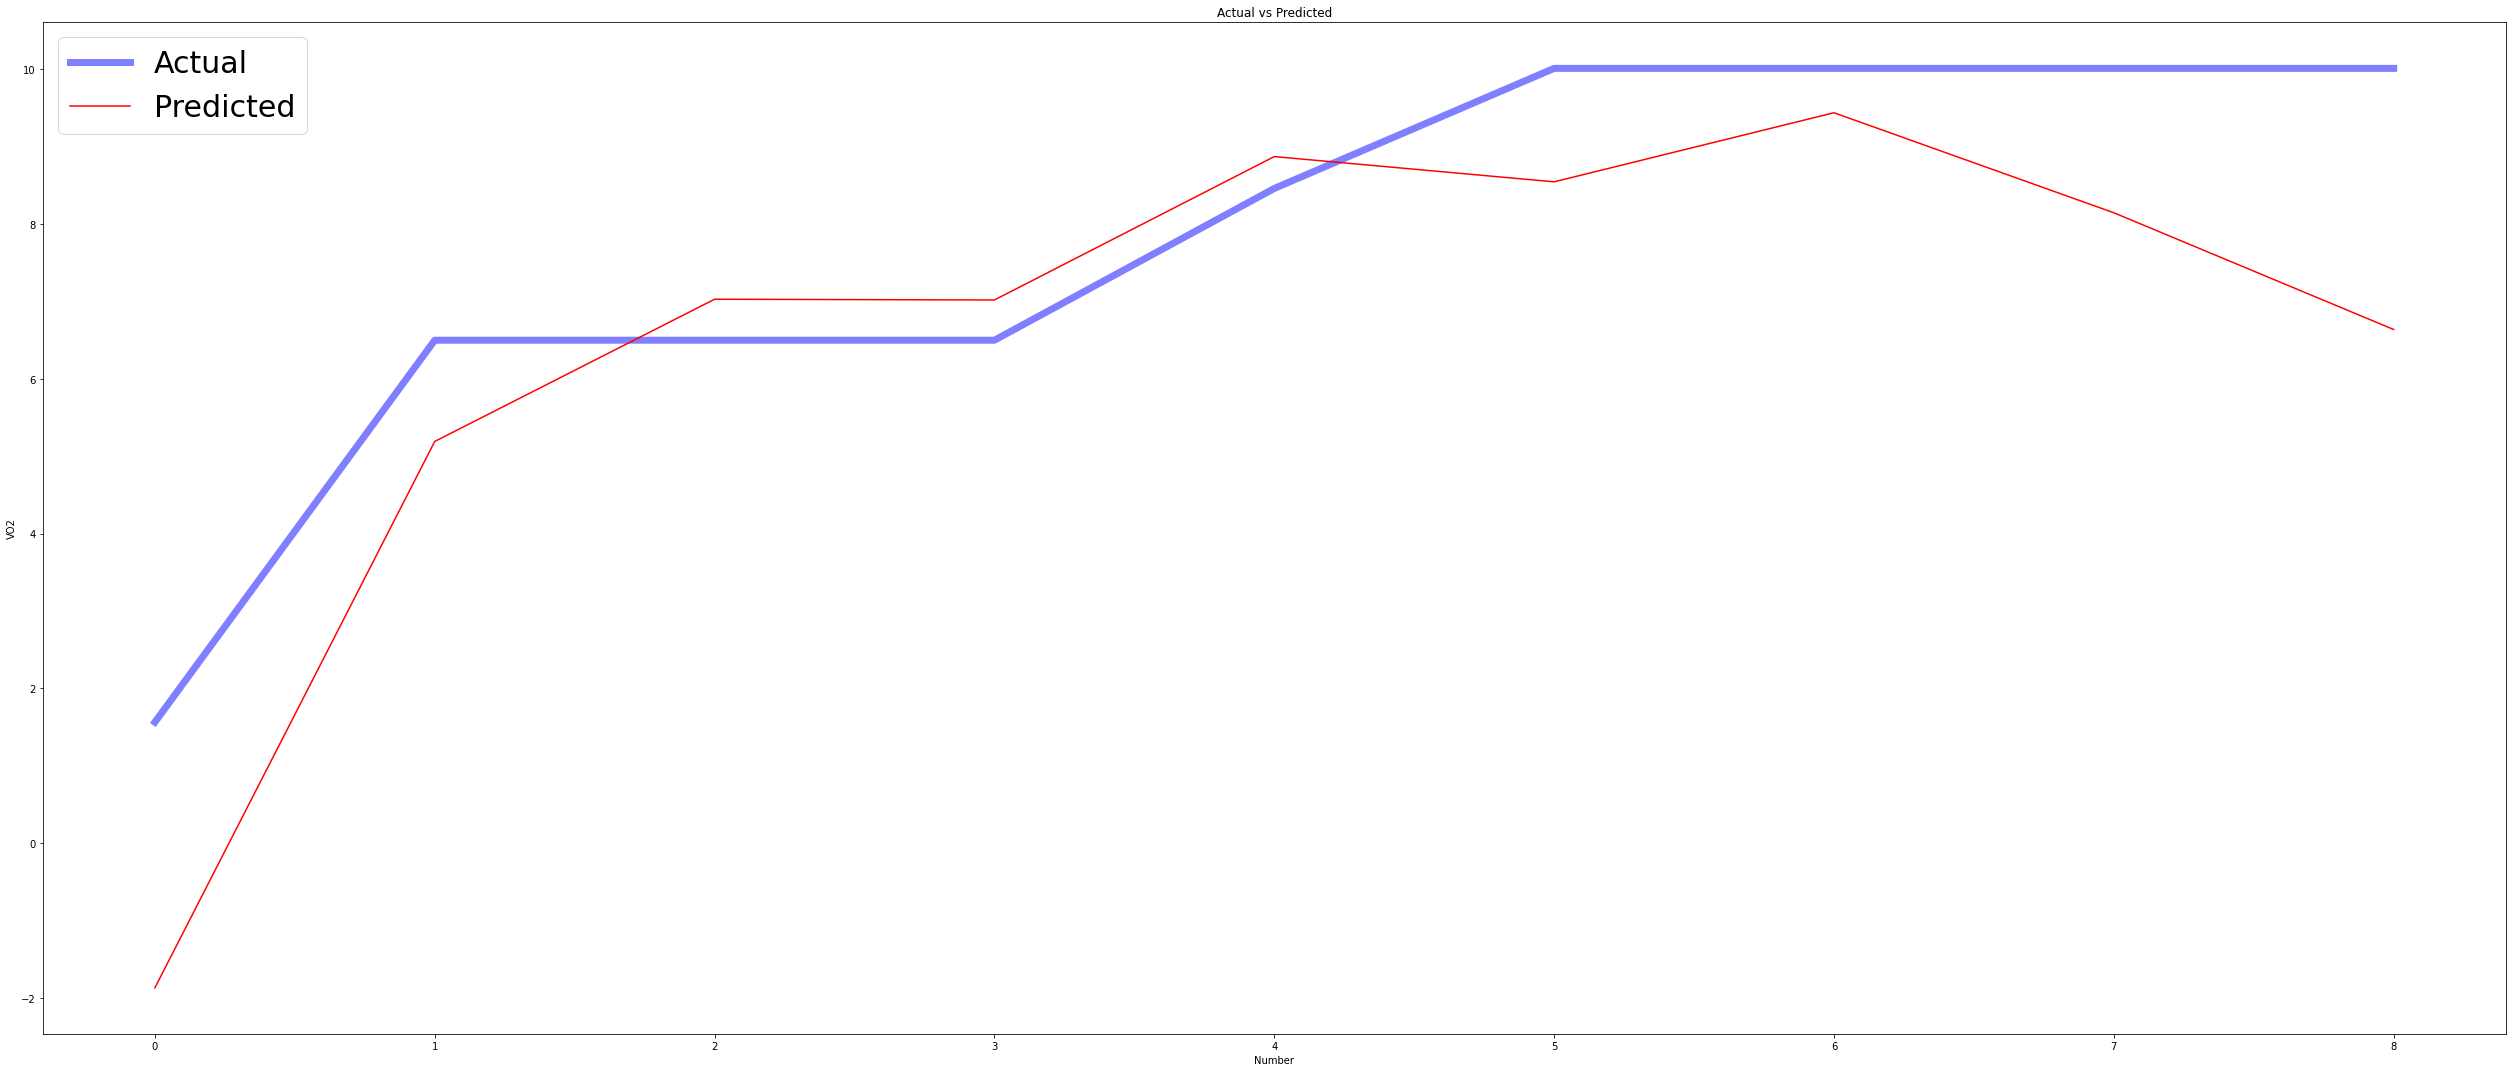

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(35,15))
plt.plot(TTest,color='blue',label='Actual',alpha=0.5,linewidth=7.0)
plt.plot(Y_hat,color='red',label='Predicted')
plt.xlabel('Number')
plt.ylabel('VO2')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.legend(prop={'size': 30})
plt.savefig(figPredictName,bbox_inches='tight',dpi=150)
plt.show()

## Save model

In [14]:
if savedModel:
    model.save(modelSaveName)

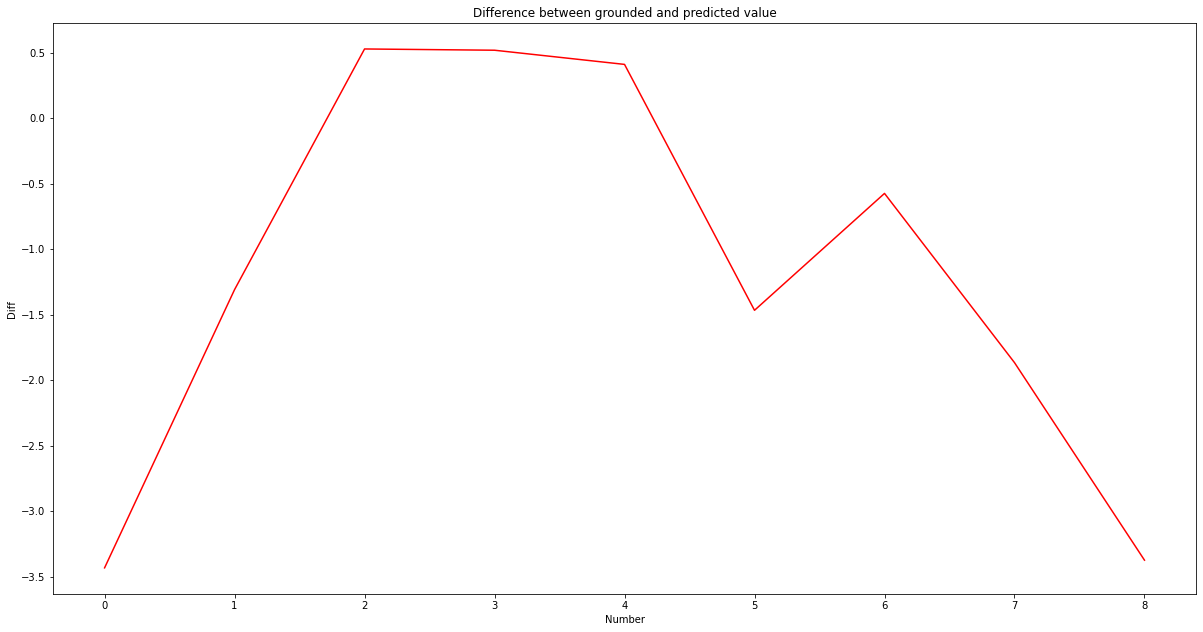

In [15]:
#Y_hat=np.transpose(Y_hat)
TTest=TTest.reshape(len(TTest),1)
#print(Y_hat)
#diff=np.concatenate((Y_hat,TTest),axis=1)
diff=np.subtract(Y_hat,TTest)
#print(diff)

plt.figure(figsize=(20.5,15.5))
plt.plot(diff,color='red')
plt.xlabel('Number')
plt.ylabel('Diff')
plt.title('Difference between grounded and predicted value')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
#fig.savefig('1st-stage-subj-1_L'+results+'.jpg', dpi=150)
plt.show()
#model.save('1st-stage-subj-1.h5')

In [18]:
res=np.concatenate((Y_hat,TTest,Y_hat-TTest,(Y_hat+TTest)/2),axis=1)
print(res)

if exportCSV:
    pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict.csv')


[[-1.87054145  1.5625     -3.43304145 -0.15402073]
 [ 5.18986988  6.4981     -1.30823012  5.84398494]
 [ 7.02770519  6.4981      0.52960519  6.7629026 ]
 [ 7.01805973  6.4981      0.51995973  6.75807987]
 [ 8.87109661  8.4593      0.41179661  8.66519831]
 [ 8.54492283 10.011      -1.46607717  9.27796141]
 [ 9.43749905 10.011      -0.57350095  9.72424952]
 [ 8.14532566 10.011      -1.86567434  9.07816283]
 [ 6.63668156 10.011      -3.37431844  8.32384078]]
